# Images of rice seeds classification

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## The dataset

This notebook uses a dataset of about 75000 photos of rice seeds from this link https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset. The dataset contains five sub-directories, one per class:

```
Rice_Image_Dataset\
    Arborio\
    Basmati\
    Ipsala\
    Jasmine\
    Karacadag\
   
```

In [34]:
data_dir = 'Datasets\Rice_Image_Dataset'
data_dir = pathlib.Path(data_dir).with_suffix('')

After downloading, you should now have a copy of the dataset available. There are 75000 total images:

In [35]:
image_count = len(list(data_dir.glob('*/*.jpg'))) 
print(image_count)

75000


Here are some Arborio rice seeds:

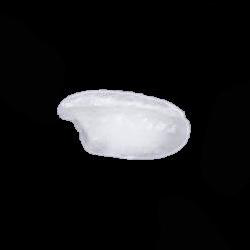

In [36]:
arborio = list(data_dir.glob('Arborio/*'))
PIL.Image.open(str(arborio[0]))

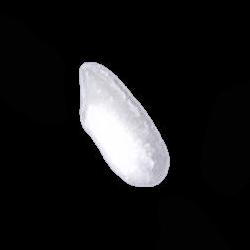

In [37]:
PIL.Image.open(str(arborio[1]))

And some bricks Jasmine rice seeds:

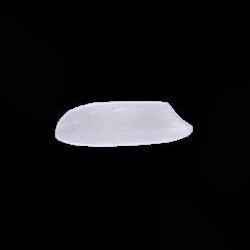

In [38]:
jasmine = list(data_dir.glob('Jasmine/*'))
PIL.Image.open(str(jasmine[0]))

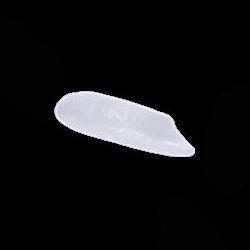

In [39]:
PIL.Image.open(str(jasmine[1]))

### Create a dataset

In [40]:
batch_size = 64
img_height = 240
img_width = 240

In [41]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=2137,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 60000 files for training.


In [42]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=2137,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [43]:
class_names = train_ds.class_names
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


## Visualize the data

Here are the first nine images from the training dataset:

In [44]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

0
1
2
3
4


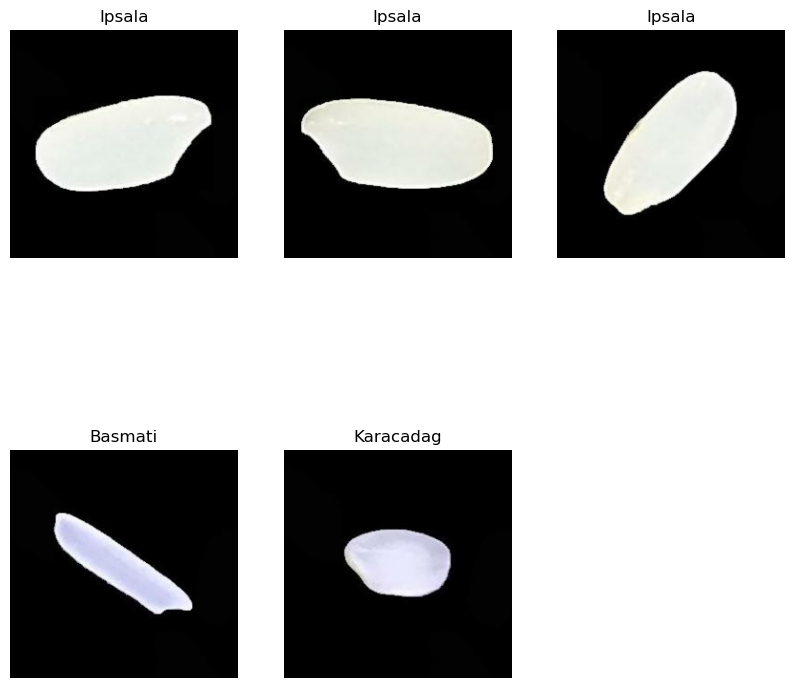

In [45]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(5):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    print(i)
    plt.axis("off")

In [46]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 240, 240, 3)
(64,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [48]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [49]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99763083


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

In [50]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
num_classes = len(class_names)

Visualize a few augmented examples by applying data augmentation to the same image several times:

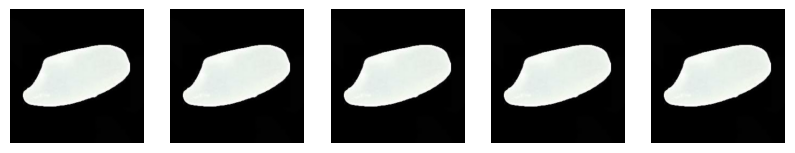

In [51]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(5):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [52]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 240, 240, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 240, 240, 16)      1216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      12832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  

In [55]:
epochs = 7
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/7
938/938 [==============================] - 77s 81ms/step - loss: 0.1796 - accuracy: 0.9357 - val_loss: 0.1091 - val_accuracy: 0.9641
Epoch 2/7
938/938 [==============================] - 75s 80ms/step - loss: 0.1085 - accuracy: 0.9635 - val_loss: 0.0480 - val_accuracy: 0.9824
Epoch 3/7
938/938 [==============================] - 73s 78ms/step - loss: 0.0407 - accuracy: 0.9875 - val_loss: 0.0248 - val_accuracy: 0.9923
Epoch 4/7
938/938 [==============================] - 73s 78ms/step - loss: 0.0306 - accuracy: 0.9905 - val_loss: 0.0342 - val_accuracy: 0.9879
Epoch 5/7
938/938 [==============================] - 73s 78ms/step - loss: 0.0260 - accuracy: 0.9914 - val_loss: 0.0268 - val_accuracy: 0.9913
Epoch 6/7
938/938 [==============================] - 74s 79ms/step - loss: 0.0249 - accuracy: 0.9917 - val_loss: 0.0281 - val_accuracy: 0.9912
Epoch 7/7
938/938 [==============================] - 74s 79ms/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.0269 - val_accuracy: 0.9916

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

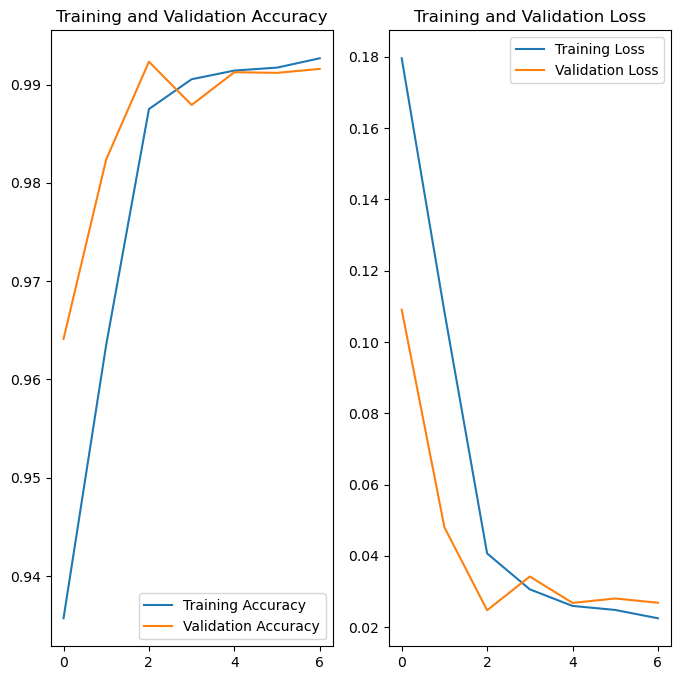

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [67]:
basmati_path = 'Datasets/Rice_new/Basmati/basmati (23).jpg'
img = tf.keras.utils.load_img(
    basmati_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Basmati with a 100.00 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model


In [68]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_rice.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\MACIEJ\AppData\Local\Temp\tmpscfumyk_\assets


INFO:tensorflow:Assets written to: C:\Users\MACIEJ\AppData\Local\Temp\tmpscfumyk_\assets


### Run the TensorFlow Lite model


In [69]:
TF_MODEL_FILE_PATH = 'model_rice.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [70]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_2_input'], 'outputs': ['outputs']}}

In [71]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [72]:
predictions_lite = classify_lite(sequential_2_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [73]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to Basmati with a 100.00 percent confidence.


In [74]:
print(np.max(np.abs(predictions - predictions_lite)))

0.0009441376
